<a href="https://colab.research.google.com/github/marcarvajalma/AlgorithmsUN2024II/blob/main/strategy_Quantiacs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable widget scrolling

<IPython.core.display.Javascript object>

In [ ]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide="ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn.naive_bayes import BernoulliNB

In [ ]:
# loading S&P500 stock data
data = qndata.stocks.load_spx_data(min_date="2005-06-01")

fetched chunk 1/13 0s
fetched chunk 2/13 0s
fetched chunk 3/13 0s
fetched chunk 4/13 0s
fetched chunk 5/13 0s
fetched chunk 6/13 0s
fetched chunk 7/13 0s
fetched chunk 8/13 0s
fetched chunk 9/13 1s
fetched chunk 10/13 1s
fetched chunk 11/13 1s
fetched chunk 12/13 1s
fetched chunk 13/13 1s
Data loaded 1s


In [ ]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price.
       These features can be modified and new ones can be added easily.
    """
    close = data.sel(field="close")
    vol = data.sel(field='vol')
    high = data.sel(field='high')
    low = data.sel(field='low')

    # trend:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)

    # moving average convergence  divergence (MACD):
    macd = qnta.macd(data.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)

    # volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14)

    # the stochastic oscillator:
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)

    # the relative strength index:
    rsi = qnta.rsi(data.sel(field="close"))

    # the logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0) # fill NaN
    price = np.log(price)

    # obv
    obv = qnta.obv(close, vol)

    # vwma
    vwma = qnta.vwma(close, vol)

    # combine the six features:
    result = xr.concat(
        [trend, macd2_signal.sel(field="close"), volatility,  d, rsi, price, obv, vwma],
        pd.Index(
            ["trend",  "macd", "volatility", "stochastic_d", "rsi", "price", "obv", "vwma"],
            name = "field"
        )
    )

    return result.transpose("time", "field", "asset")

In [ ]:
# displaying the features:
my_features = get_features(data)
display(my_features.sel(field="trend").to_pandas())

asset,NAS:AAL,NAS:AAPL,NAS:ABNB,NAS:ACGL,NAS:ADBE,NAS:ADI,NAS:ADP,NAS:ADSK,NAS:AEP,NAS:AKAM,...,NYS:WMB,NYS:WMT,NYS:WRB,NYS:WST,NYS:WY,NYS:XOM,NYS:XYL,NYS:YUM,NYS:ZBH,NYS:ZTS
time,,,,,,,,,,,,,,,,,,,,,
2005-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,0.143845,-0.020030,-0.076572,-0.081199,-0.266023,-0.072554,0.055300,0.116794,0.101628,0.164671,...,-0.040805,0.254796,-0.062078,0.127679,0.054951,-0.183828,0.071539,-0.067031,0.032042,-0.010647
2025-02-03,0.090432,-0.132496,-0.108737,-0.078502,-0.253000,-0.170161,0.100157,0.056200,0.135289,0.099523,...,0.000272,0.293441,-0.025253,0.078899,0.070318,-0.172418,0.035621,-0.041365,-0.009125,0.013060
2025-02-04,0.105387,-0.068328,-0.082237,-0.088984,-0.236719,-0.153932,0.067596,0.059558,0.083713,0.164757,...,-0.031628,0.325827,0.015423,0.016252,0.004675,-0.081557,0.210129,-0.041607,-0.019921,0.019913


In [ ]:
def get_target_classes(data):
    """Target classes for predicting if price goes up or down."""
    daily_return = qnta.change(data.sel(field="close")) / (data.sel(field="close").shift(time=+1))
    daily_return_future = daily_return.shift(time=-1)

    move = 0.005

    class_positive = 1  # price goes up more than move*100%
    class_neutral = 0   # price did not move more than move*100%
    class_negative = -1  # price goes down more than move*100%

    target_price = xr.where(daily_return_future < -move, class_negative, daily_return_future)
    target_price = xr.where(target_price > move, class_positive, target_price)
    target_price = xr.where(abs(target_price) != 1, class_neutral, target_price)

    return target_price

In [ ]:
# displaying the target classes:
my_targetclass = get_target_classes(data)
display(my_targetclass.to_pandas())

asset,NAS:AAL,NAS:AAPL,NAS:ABNB,NAS:ACGL,NAS:ADBE,NAS:ADI,NAS:ADP,NAS:ADSK,NAS:AEP,NAS:AKAM,...,NYS:WMB,NYS:WMT,NYS:WRB,NYS:WST,NYS:WY,NYS:XOM,NYS:XYL,NYS:YUM,NYS:ZBH,NYS:ZTS
time,,,,,,,,,,,,,,,,,,,,,
2005-06-01,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,-1.0,...,0.0,1.0,-1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0
2005-06-02,0.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,...,1.0,-1.0,0.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,0.0
2005-06-03,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.0,0.0
2005-06-06,0.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,1.0,0.0,1.0,...,-1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2005-06-07,0.0,1.0,0.0,1.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,...,0.0,0.0,-1.0,1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,-1.0,-1.0,-1.0,0.0,0.0,-1.0,1.0,-1.0,1.0,-1.0,...,1.0,1.0,1.0,-1.0,0.0,0.0,-1.0,1.0,-1.0,1.0
2025-02-03,1.0,1.0,1.0,0.0,0.0,0.0,-1.0,0.0,-1.0,1.0,...,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,0.0,0.0,0.0
2025-02-04,1.0,0.0,-1.0,0.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
def get_model():
    """
    Constructor para el modelo de Machine Learning (Bernoulli Naive Bayes).
    """
    model = BernoulliNB(
        alpha=1.0,  # Parámetro de suavizado de Laplace
        binarize=0.0,  # Umbral para binarizar los datos (0 y 1)
        fit_prior=True  # Ajustar los priors a partir de los datos
    )
    return model

In [ ]:
# Create and train the models working on an asset-by-asset basis.

asset_name_all = data.coords["asset"].values

models = dict()

for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = my_targetclass.sel(asset=asset_name).dropna(dim="time", how="any")
        features_cur = my_features.sel(asset=asset_name).dropna(dim="time", how="any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

print(models)

{'NAS:AAL': BernoulliNB(), 'NAS:AAPL': BernoulliNB(), 'NAS:ABNB': BernoulliNB(), 'NAS:ACGL': BernoulliNB(), 'NAS:ADBE': BernoulliNB(), 'NAS:ADI': BernoulliNB(), 'NAS:ADP': BernoulliNB(), 'NAS:ADSK': BernoulliNB(), 'NAS:AEP': BernoulliNB(), 'NAS:AKAM': BernoulliNB(), 'NAS:ALGN': BernoulliNB(), 'NAS:AMAT': BernoulliNB(), 'NAS:AMD': BernoulliNB(), 'NAS:AMGN': BernoulliNB(), 'NAS:AMZN': BernoulliNB(), 'NAS:ANSS': BernoulliNB(), 'NAS:APA': BernoulliNB(), 'NAS:AVGO': BernoulliNB(), 'NAS:AXON': BernoulliNB(), 'NAS:BIIB': BernoulliNB(), 'NAS:BKNG': BernoulliNB(), 'NAS:BKR': BernoulliNB(), 'NAS:CDNS': BernoulliNB(), 'NAS:CDW': BernoulliNB(), 'NAS:CEG': BernoulliNB(), 'NAS:CHRW': BernoulliNB(), 'NAS:CHTR': BernoulliNB(), 'NAS:CINF': BernoulliNB(), 'NAS:CMCSA': BernoulliNB(), 'NAS:CME': BernoulliNB(), 'NAS:COO': BernoulliNB(), 'NAS:COST': BernoulliNB(), 'NAS:CPB': BernoulliNB(), 'NAS:CPRT': BernoulliNB(), 'NAS:CRWD': BernoulliNB(), 'NAS:CSCO': BernoulliNB(), 'NAS:CSGP': BernoulliNB(), 'NAS:CSX': 

In [ ]:
# Performs prediction and generates output weights:
is_liquid = data.sel(field="is_liquid") # Se agrega para trabajar con liquidez
asset_name_all = data.coords["asset"].values
weights = xr.zeros_like(data.sel(field="close"))
weights = weights * is_liquid

for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna(dim="time", how="any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception("model prediction failed")

print(weights)

<xarray.DataArray 'stocks_s&p500' (time: 4954, asset: 516)> Size: 20MB
array([[nan,  0., nan, ...,  0.,  0., nan],
       [nan,  0., nan, ...,  0.,  0., nan],
       [nan,  0., nan, ...,  0.,  0., nan],
       ...,
       [-1.,  1.,  1., ...,  1.,  0.,  0.],
       [-1.,  1.,  1., ...,  1.,  0.,  0.],
       [-1.,  1.,  1., ...,  0.,  0.,  0.]])
Coordinates:
  * time     (time) datetime64[ns] 40kB 2005-06-01 2005-06-02 ... 2025-02-06
  * asset    (asset) <U9 19kB 'NAS:AAL' 'NAS:AAPL' ... 'NYS:ZBH' 'NYS:ZTS'


In [ ]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights*is_liquid)
sharpe

0.8231480227999253

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-31,11.354172,-0.005275,0.159732,-0.018967,-0.368225,0.824275,0.131663,0.822715,507.0,0.091572,20.878819
2025-02-03,11.284854,-0.006105,0.159722,-0.024956,-0.368225,0.821937,0.131282,0.818182,507.0,0.091568,20.880398
2025-02-04,11.289737,0.000433,0.159706,-0.024534,-0.368225,0.821999,0.131278,0.817175,507.0,0.091567,20.882141
2025-02-05,11.340403,0.004488,0.159693,-0.020157,-0.368225,0.823507,0.131508,0.808989,507.0,0.091560,20.881339
2025-02-06,11.332093,-0.000733,0.159677,-0.020875,-0.368225,0.823148,0.131438,0.807910,507.0,0.091554,21.060840


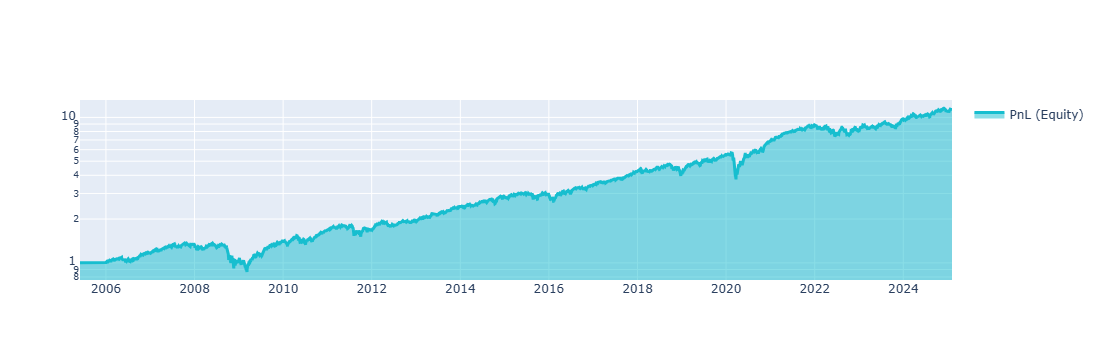

time,2025-02-06
field,
sharpe_ratio,0.823148


WARNING! This strategy correlates with other strategies and will be rejected.
Modify the strategy to produce the different output.


The number of systems with a larger Sharpe ratio and correlation larger than 0.9: 26
The max correlation value (with systems with a larger Sharpe ratio): 0.9857656737286947
Current sharpe ratio(3y): 0.6897276280068592



In [ ]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(data, weights*is_liquid)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,data)

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [ ]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna(dim="time", how="any")
        features_cur = features_all.sel(asset=asset_name).dropna(dim="time", how="any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

    return models

In [ ]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="close"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna(dim="time", how="any")

            if len(features_cur.time) < 1:
                continue

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except:
                logging.exception("model prediction failed")

    return weights

In [ ]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              ="stocks_s&p500",
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

Run the last iteration...


100% (79197 of 79197) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (13075412 of 13075412) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/2 4s


100% (3382280 of 3382280) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/2 5s
Data loaded 5s


100% (1229312 of 1229312) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/1 6s
Data loaded 6s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write output: /root/fractions.nc.gz
State saved.
---
Run First Iteration...


100% (79197 of 79197) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (13232876 of 13232876) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/2 4s


100% (3423008 of 3423008) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/2 5s
Data loaded 5s
---
Run all iterations...
Load data...


100% (79197 of 79197) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (13047640 of 13047640) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/15 1s


100% (13045396 of 13045396) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/15 2s


100% (13049884 of 13049884) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/15 2s


100% (13045400 of 13045400) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/15 3s


100% (13049864 of 13049864) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/15 4s


100% (13049864 of 13049864) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/15 5s


100% (13047552 of 13047552) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/15 6s


100% (13047552 of 13047552) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 8/15 6s


100% (13004916 of 13004916) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 9/15 7s


100% (13045308 of 13045308) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 10/15 8s


100% (13004916 of 13004916) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 11/15 9s


100% (13047552 of 13047552) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 12/15 10s


100% (13049796 of 13049796) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 13/15 11s


100% (13049796 of 13049796) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 14/15 11s


100% (9700316 of 9700316) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 15/15 12s
Data loaded 12s


100% (79197 of 79197) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (12967236 of 12967236) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/13 1s


100% (12967240 of 12967240) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/13 1s


100% (12967236 of 12967236) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/13 2s


100% (12967240 of 12967240) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/13 3s


100% (12967212 of 12967212) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/13 4s


100% (12967132 of 12967132) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/13 4s


100% (12967132 of 12967132) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/13 5s


100% (12920980 of 12920980) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 8/13 6s


100% (12967132 of 12967132) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 9/13 7s


100% (12920980 of 12920980) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 10/13 7s


100% (12967132 of 12967132) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 11/13 8s


100% (12967132 of 12967132) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 12/13 9s


100% (11672572 of 11672572) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 13/13 10s
Data loaded 10s
Backtest...


 99% (5030 of 5057) |################### | Elapsed Time: 0:07:33 ETA:   0:00:02

The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

! conda install -y scikit-learn

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low  = data.sel(field="low") * 1.0
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**.

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**.

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages.

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!